# **Common Prosperity Simulation**
## Computational Physics Lab 
Author: Yuan-Yen Peng, Chih-Tian Ho  
E-mail: garyphys0915@gapp.nthu.edu.tw, chihtian.ho@gapp.nthu.edu.tw  
Dept of Physics, NTHU, Taiwan   
Date: 
Version: 2.0  
License: MIT

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.animation as animation
from pathlib import Path
from numba import jit, njit, prange, set_num_threads
import glob

### initial conditions

In [16]:
# initial setup
problem_name = 'Common_Prosperity'
io_screen = True
io_freq = 5 # how many step to record the data
io_title = problem_name

In [17]:
# setup

# initial conditions
width, length = 100, 100
N = int(width * length)
J = 0.5 # energy constant

n = 100 # time steps
tags = np.arange(0, N).reshape((width, length)) # label of position
tmax = 1.5 # [code unit]
dt = 0.1 # [code unit]

# set the standard diviation for x & y are both 3 
sigma_x, sigma_y = 10.0, 10.0

# set eta, will be adjust by results (absorbing coeff)
eta = 10e-5

### Grid generator

In [18]:
def grid_generator(width, length, init_rank:float = 3.0, dec: int = 2):
  '''
  This is a grid generator
  :para width: width of the grid
  :para length: lerngth of the grid
  :para init_rank: bounds of initial rank of the grid; i.e., if use 3, --> [-3, 3]
  :para dec: decimal for the function <round>
  '''

  grid_positive = np.round(init_rank * np.random.random(int(N/2)), dec)
  grid_negative = np.round(-init_rank * np.random.random(int(N/2)), dec)
  grid = np.append(grid_positive, grid_negative)
  for _ in range(10): np.random.shuffle(grid) # set it to random
  grid = grid.reshape((width, length))

  # add the boundaries to four margins with minimum initial rank - 1
  tor = - (init_rank + 1)
  res = np.array([tor * np.ones(length)])
  grid_boundary = np.concatenate((res, grid, res), axis=0)
  grid_boundary = np.insert(grid_boundary, (0, length), tor, axis=1)

  return grid, grid_boundary

In [19]:
def plot(arr, header, size = 8, dpi = 80):
  '''
  :para arr: input data: 2D Array
  '''

  figure(figsize=(size, size), dpi=dpi)
  plt.imshow(arr, cmap='coolwarm', extent=[-width/2,width/2,-length/2,length/2], alpha=.85)
  plt.colorbar()
  plt.title(f'{header}')
  plt.ioff()

  return

### output

make the directories

In [20]:
io_folder = "data_" + io_title
Path(io_folder).mkdir(parents=True, exist_ok=True)
io_folder_fig = "fig_" + io_title
Path(io_folder_fig).mkdir(parents=True, exist_ok=True)

output figures

In [21]:
def output_fig(n, arr, time):
  """
  Write simulation data into a file named "fig"
  """
  header = "Time = {}".format(time)
  plot(arr, header)
  fig = f'{io_folder_fig}/fig_{io_title}_{str(n).zfill(1)}.png'
  plt.savefig(fig)
  return 

In [22]:
# # test

# arr = grid_generator(width, length, init_rank = 3.0, dec = 2)
# output_fig(12, arr[0], 23)
# print(arr[1])

output info files

### main exchange functions

In [23]:
spin = grid_generator(width, length, init_rank = 3.0, dec = 2)[1] # include boundary

In [24]:
# Energy (each time)

@njit(parallel = True) # faster than jit if using "parallel"
def energy(spin, tags, J, h):
  energy = tags
  for i in prange(width):
    for j in prange(length):
      s_cen  = spin[i+1, j+1]
      
      s_up   = spin[i  , j+1]
      s_rig  = spin[i+1, j+2]
      s_down = spin[i+2, j+1]
      s_lef  = spin[i+1, j  ]

      energy[i, j] = -J * s_up * s_rig * s_down * s_lef - h * s_cen

  return energy

In [25]:
# Background fucn

@njit(parallel = True)
def bkg(N, sigma_x, sigma_y):
  # set Background function as BG in size(N,N)
  l_include = int(np.sqrt(N)) + 2
  BKG = np.ones((l_include, l_include))
  for i in prange(100):
        for j in prange(100):
            BKG[i, j] = (np.exp(-((i - l_include/2 + 2 )**2 / (2*sigma_x**2) 
                        + (j - l_include/2 + 2 )**2 / (2*sigma_y**2))))
  return BKG

In [26]:
# Spin (each time)

@njit(parallel = True)
def self(N, spin, bkg, eta):
  '''
    1) set another array called new playground as nspin to save the new Hierarchy, 
      and update when all units are calculated.
    2) note that no need for bkg since they are indep. for each
    :param N: N sites

  '''
  l = int(np.sqrt(N))
  nspin = spin # this is temp of spin (which depend on spin)
  for i in prange(2, l+1):
      for j in prange(2, l+1):
          nspin[i,j] += ((1 / np.sqrt(2*3**2)) * np.exp(-(spin[i,j]/(2 * 3**2))) 
                        * (-(4*spin[i,j] - spin[i,j+1] -spin[i,j-1] - spin[i-1,j] - spin[i+1,j])) 
                        + eta * (np.exp(5)/2 * np.exp(spin[i,j]) 
                                + (1 / (2*np.sqrt(2*3**2))) * np.exp(-(spin[i,j]/(2*3**2)))) * bkg[i,j])
          
          bkg[i,j] += (- eta * (np.exp(5)/2 * np.exp(spin[i,j]) 
                                + (1 / (2*np.sqrt(2*3**2))) * np.exp(-(spin[i,j]/(2*3**2)))) * bkg[i,j])
          # only decay with the time 

  spin = nspin # temp of spin = new spin

  return spin

In [27]:
# main (loop of time)

def main(N, n, dt, tmax, tags, spin, J, sigma_x, sigma_y, eta):
    dt = tmax / n
    t = 0
    
    h = 0 # set no bkg influences in the beginning
    Header1 = f"Initial spin, time = {t}"
    Header2 = f"Initial energy, time = {t}"
    Ei = energy(spin, tags, J, h)
    # plot(spin, Header1, size = 8, dpi=100)
    # plot(Ei, Header2, size = 8, dpi=100)
    Ei = np.delete(Ei, (0, -1), 0)
    Ei = np.delete(Ei, (0, -1), 1)
    Si = np.delete(spin, (0, -1), 0)
    Si = np.delete(Si, (0, -1), 1)
    plot(Si, Header1, size = 8, dpi=100)
    plot(Ei, Header2, size = 8, dpi=100)
    
    while t < tmax:
      # update data
      bk = bkg(N, sigma_x, sigma_y)
      h = 30 * np.average(bk)
      epsilon = energy(spin, tags, J, h)
      spin = self(N, spin, bk, eta)
      
      E = np.delete(epsilon, (0, -1), 0)
      E = np.delete(E, (0, -1), 1)
      S = np.delete(spin, (0, -1), 0)
      S = np.delete(S, (0, -1), 1)
      
      # output files
      if (n % io_freq == 0):
        if io_screen:
            '''
            output info files

            '''
            header1 = f"spin, time = {t+dt}"
            header2 = f"energy, time = {t+dt}"
            plot(S, header1, size = 8, dpi=100)
            plot(E, header2, size = 8, dpi=100)
            # fn = io_folder + "/data_" + io_title + "_" + str(n).zfill(3) + ".txt"
            # print(fn)
            output_fig(n, spin, t) # :para arr: arr is a matrix of the grid in time t.
            output_fig(n, epsilon, t)
            
      # update time
      n += 1
      t += dt
      if t + dt > tmax:
        dt = tmax - t

    return print("Done!")

<ipython-input-19-f6204c2c8531>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(size, size), dpi=dpi)


Done!


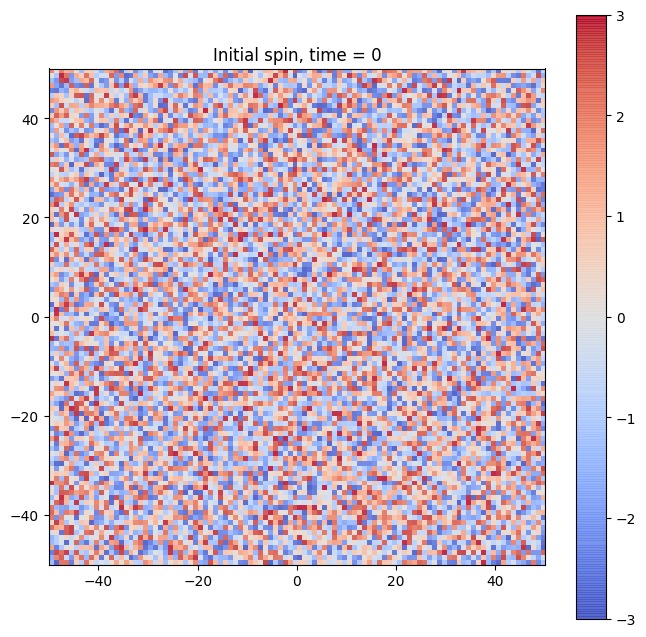

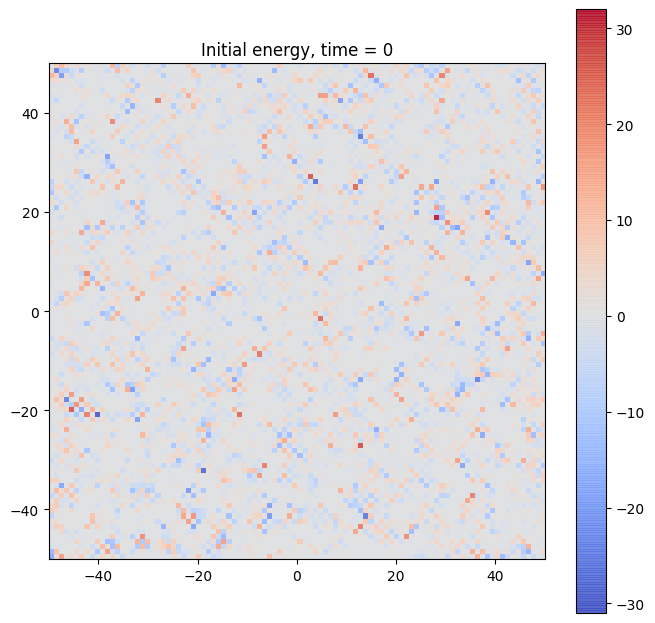

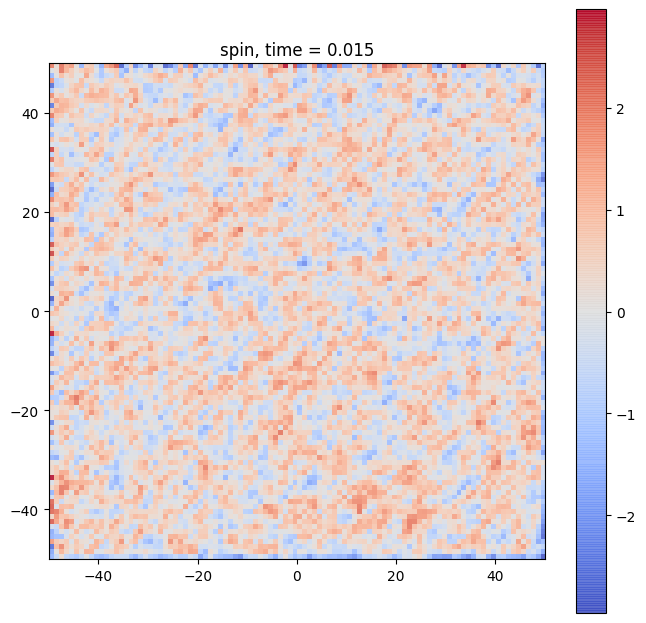

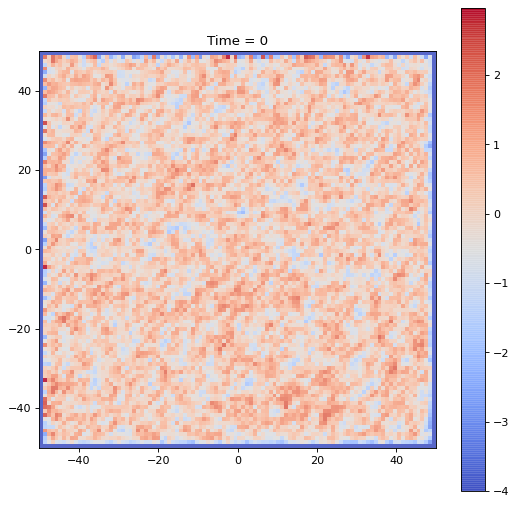

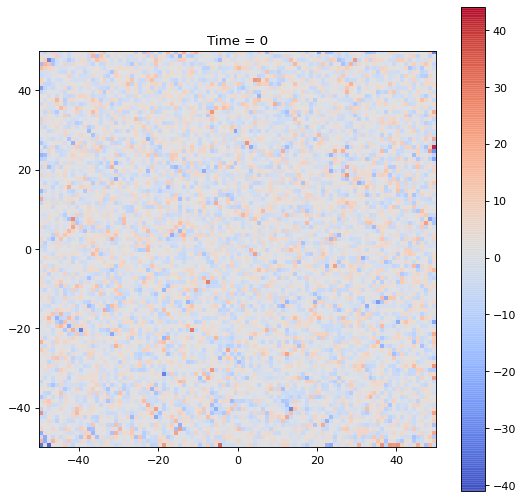

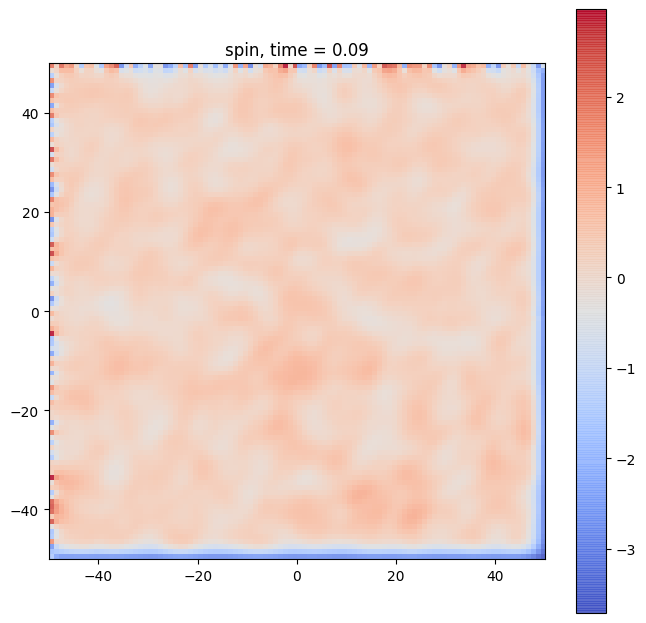

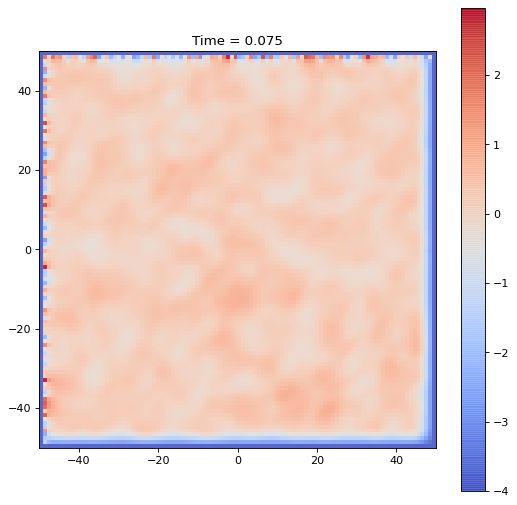

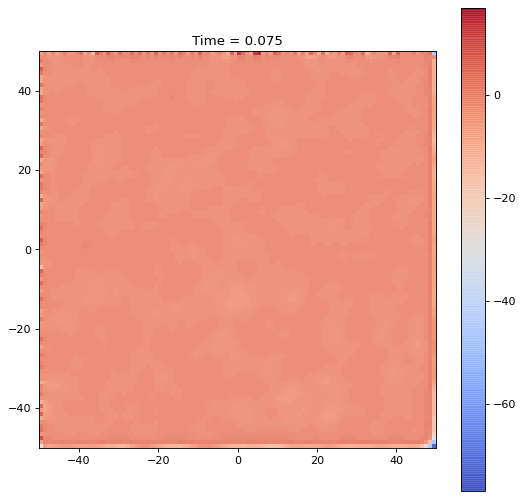

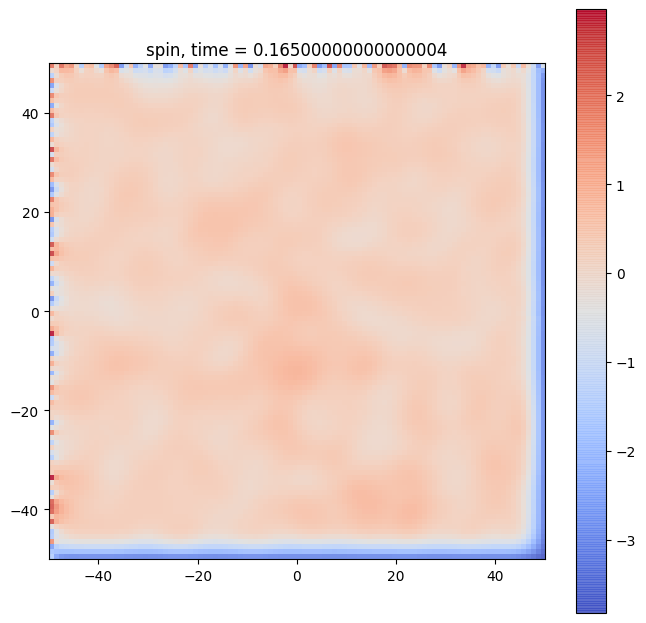

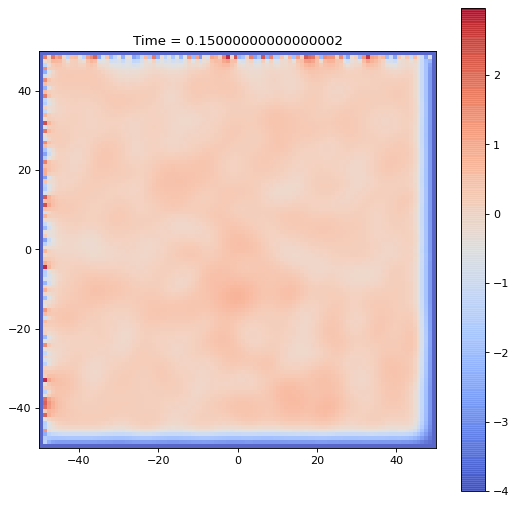

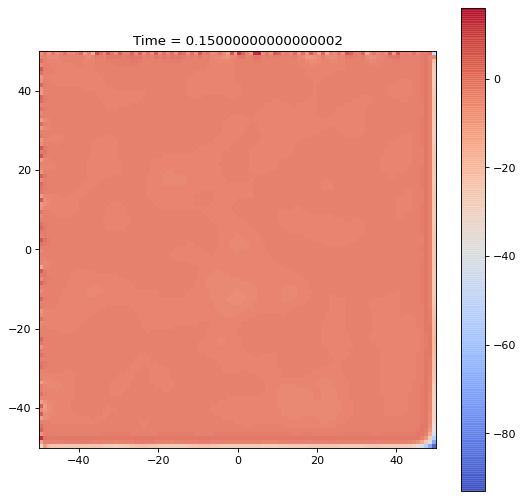

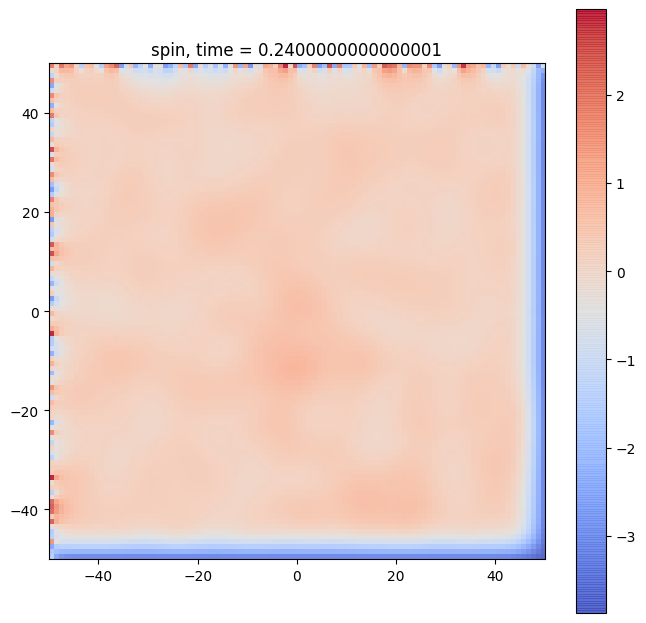

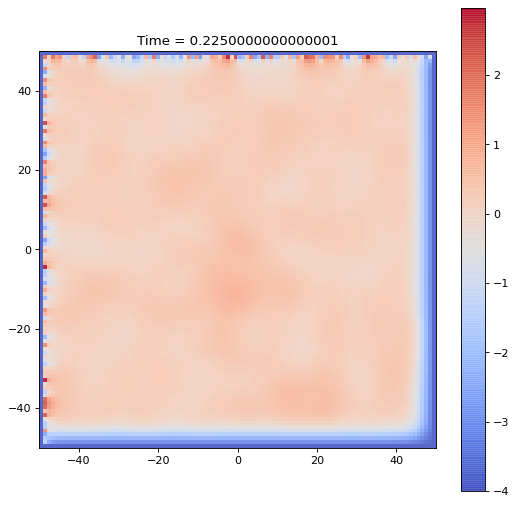

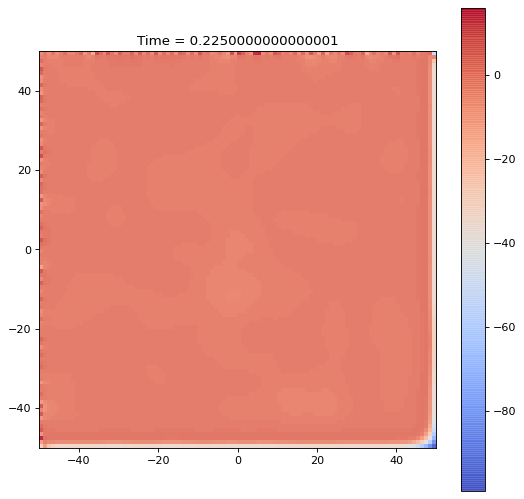

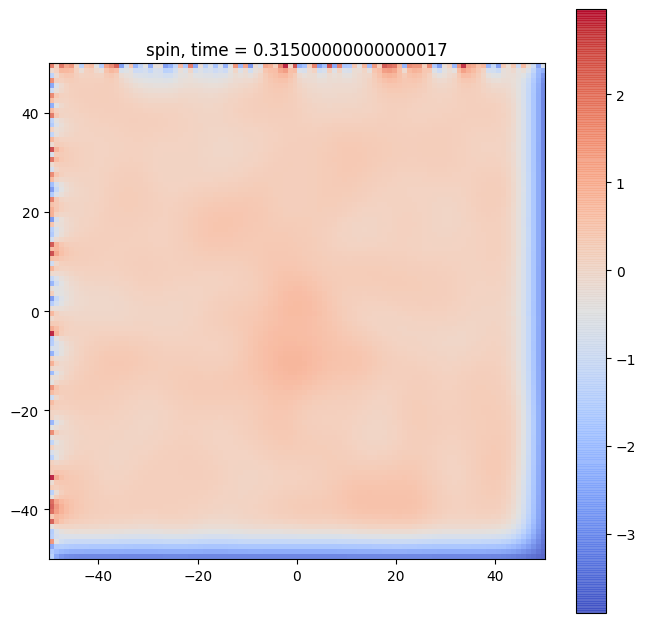

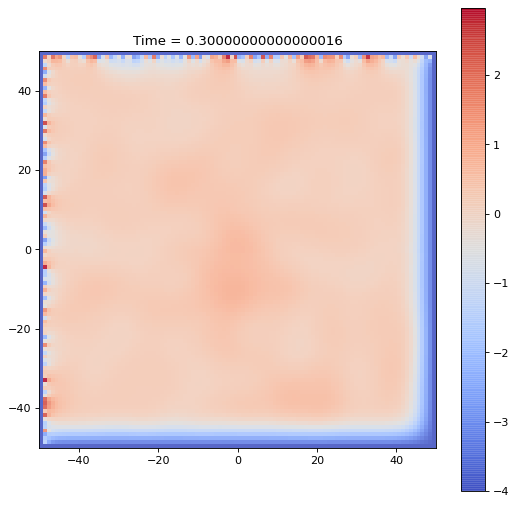

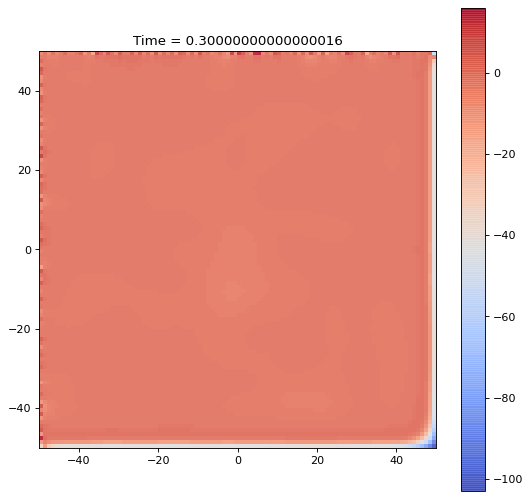

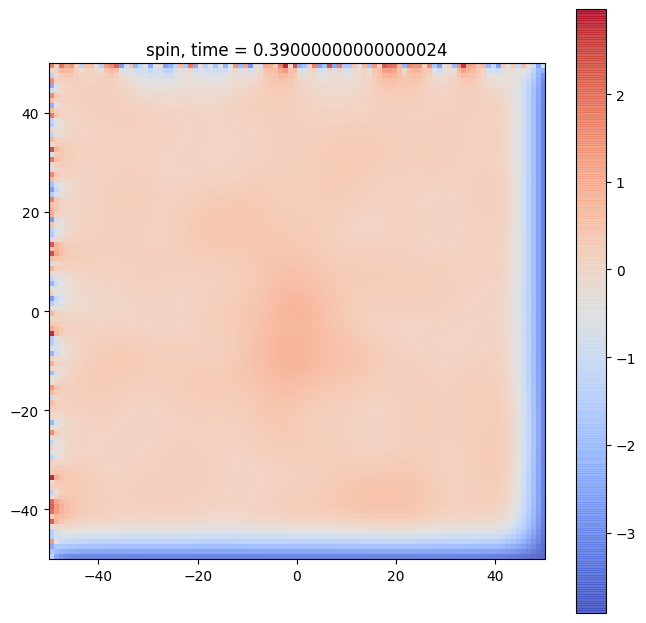

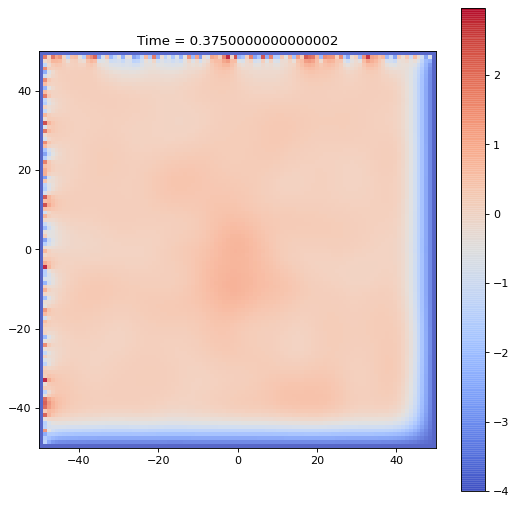

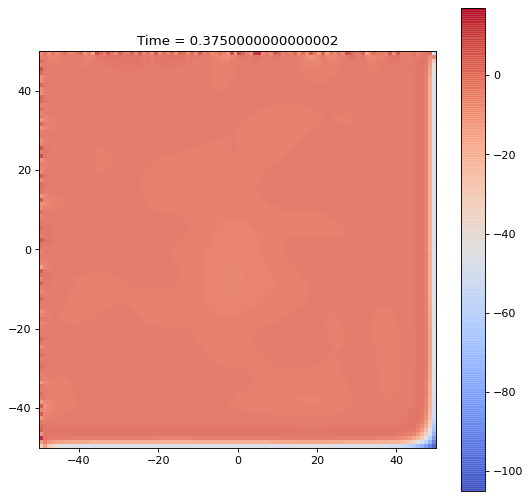

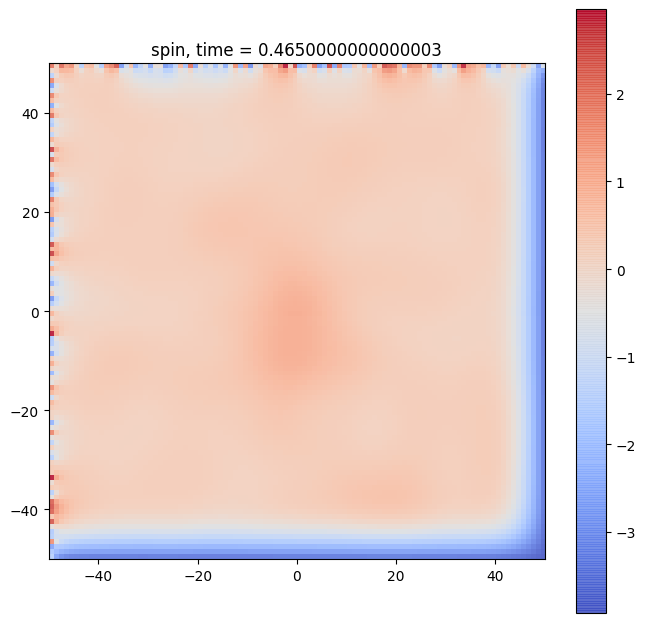

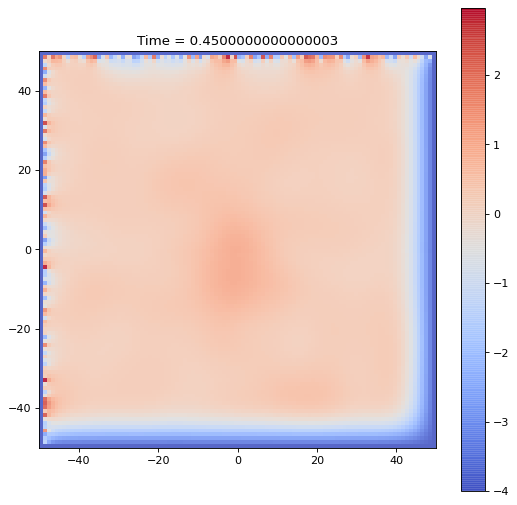

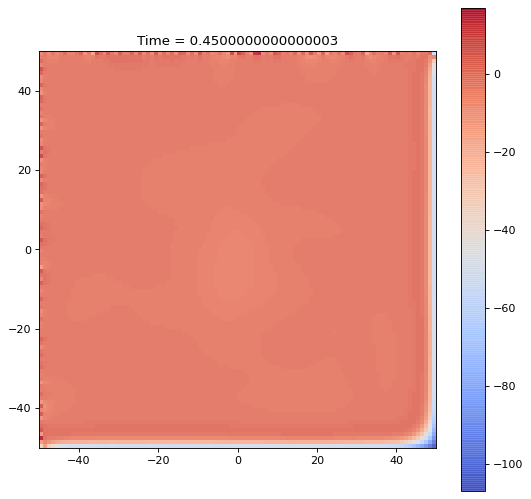

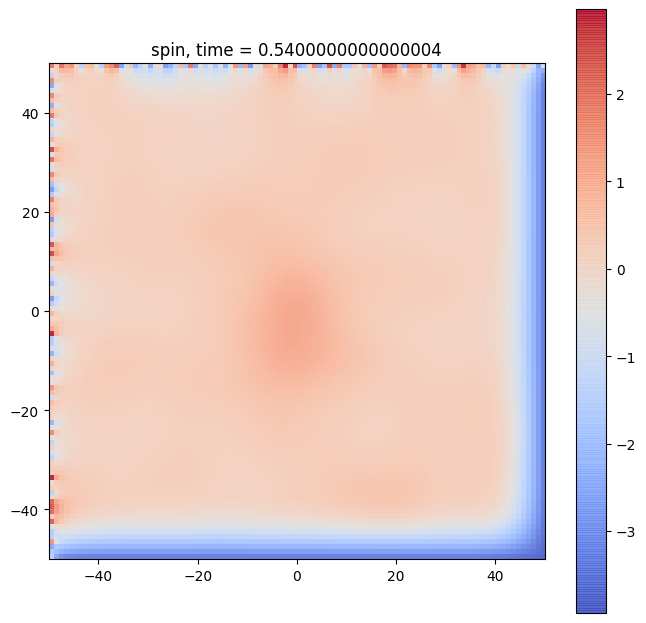

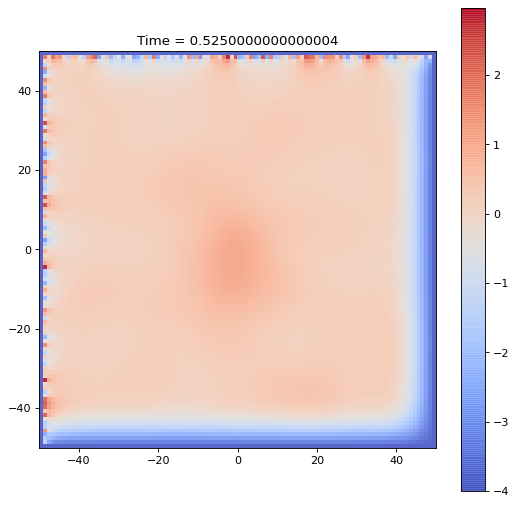

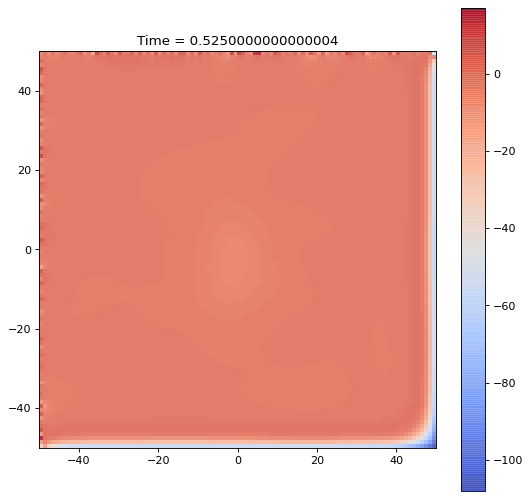

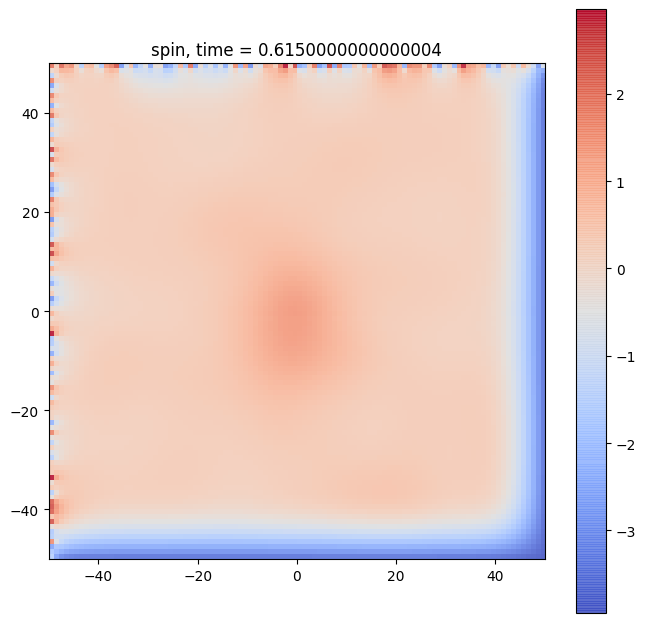

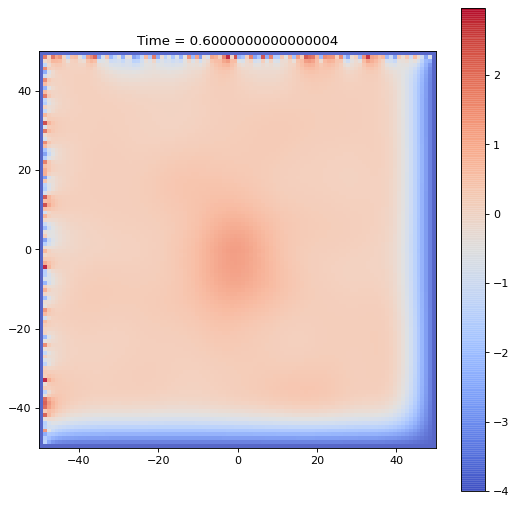

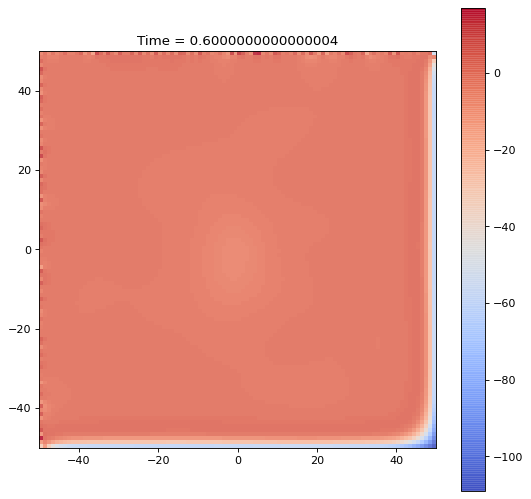

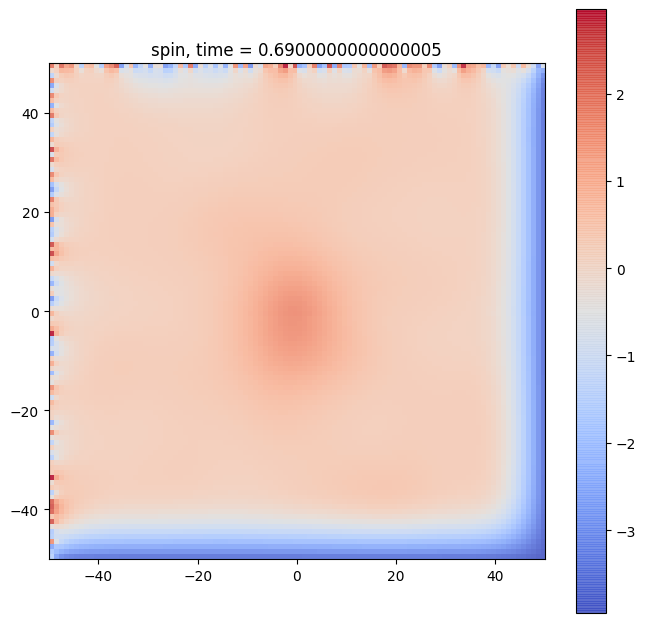

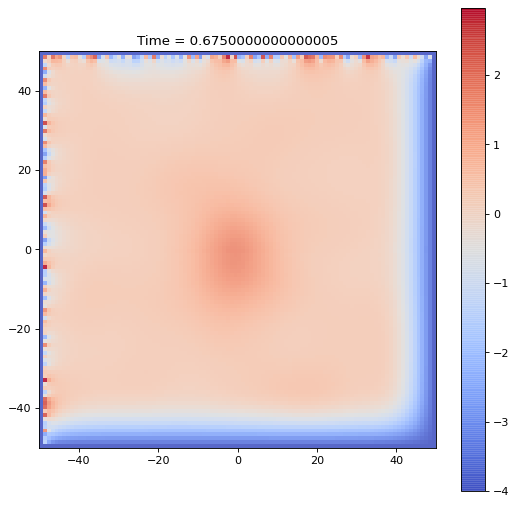

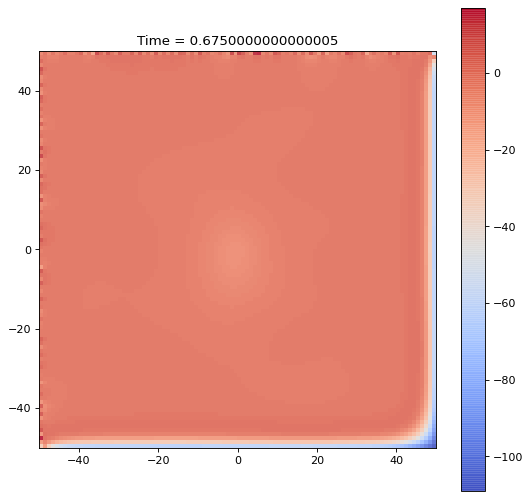

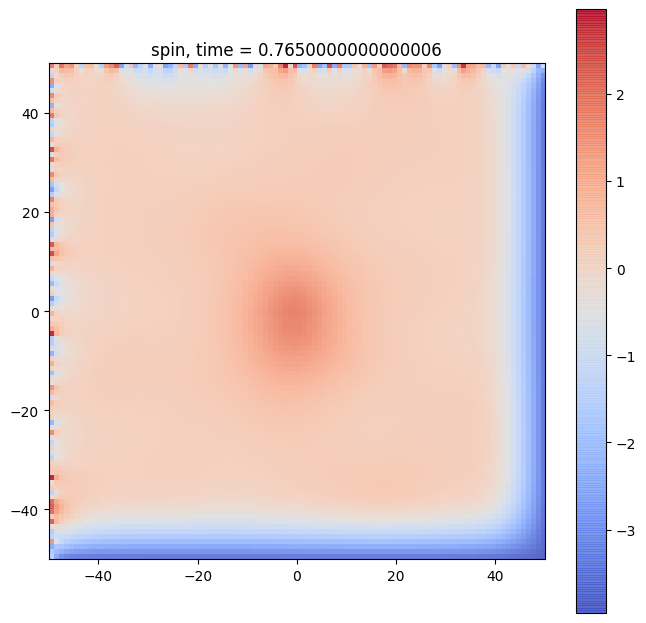

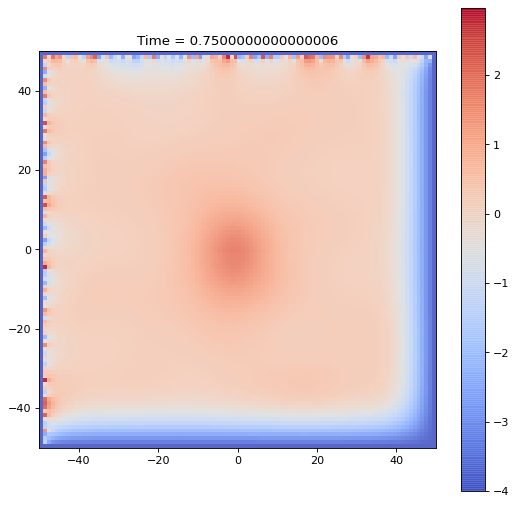

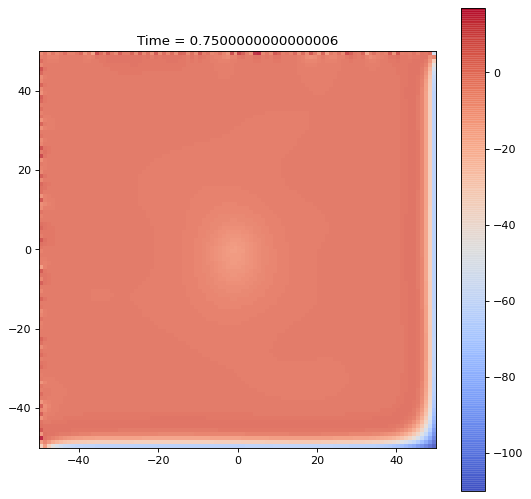

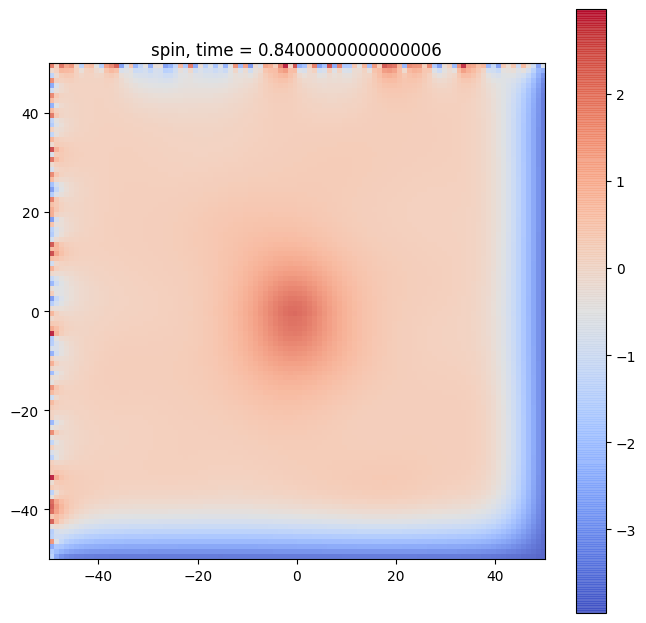

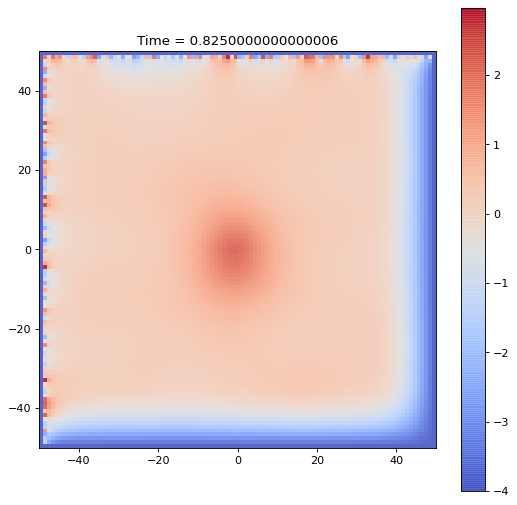

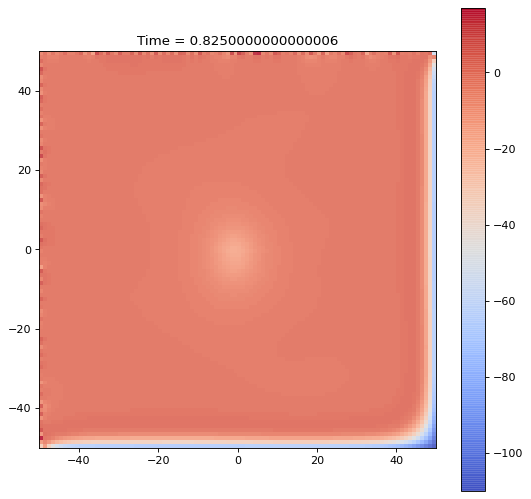

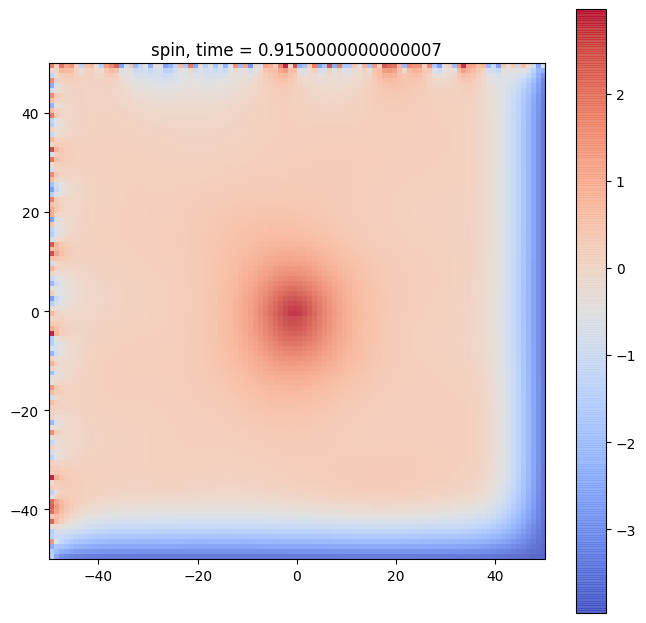

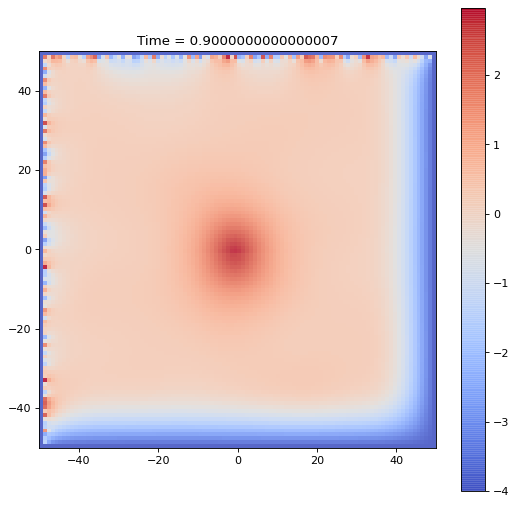

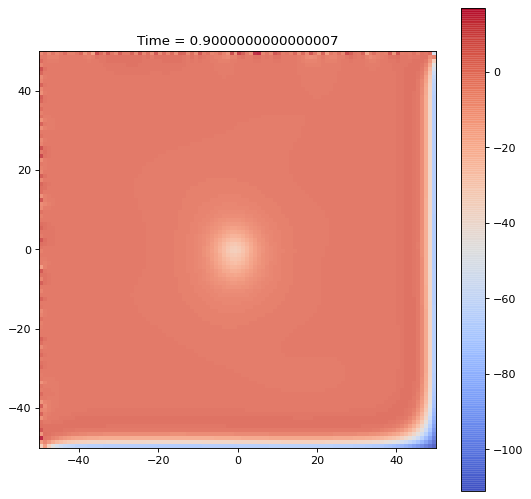

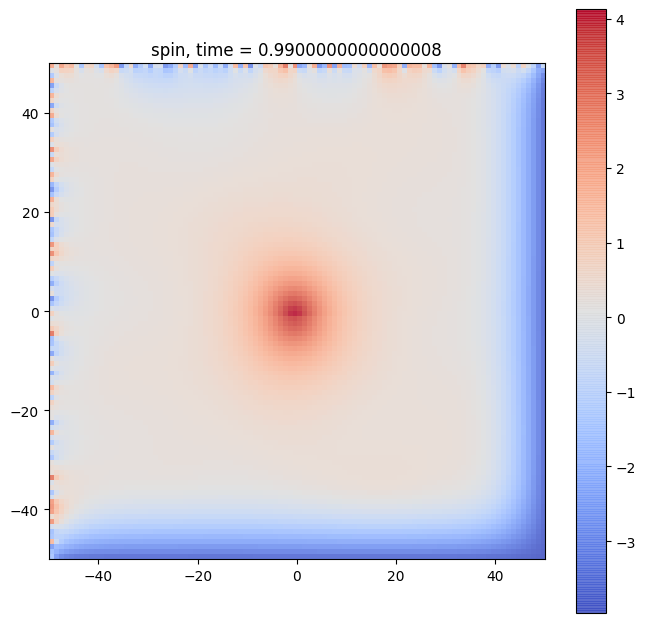

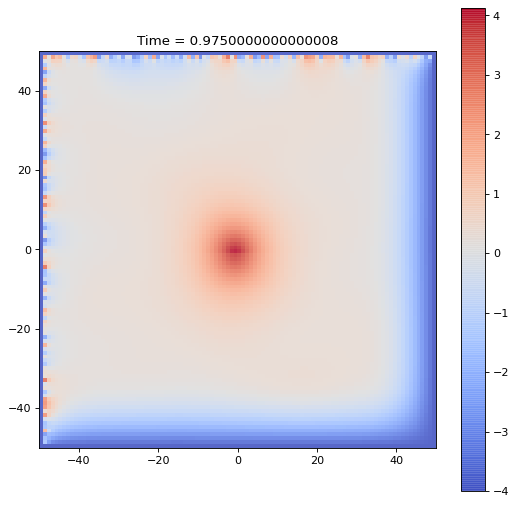

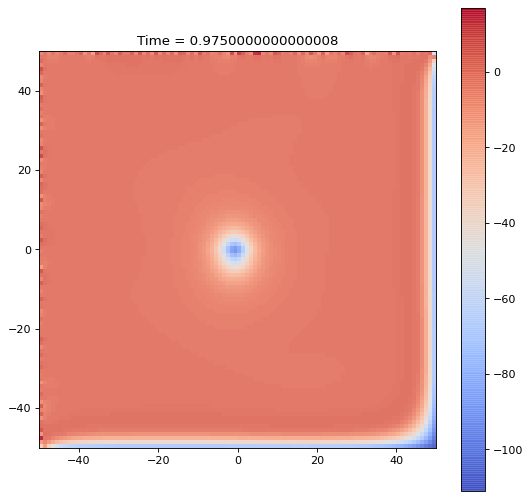

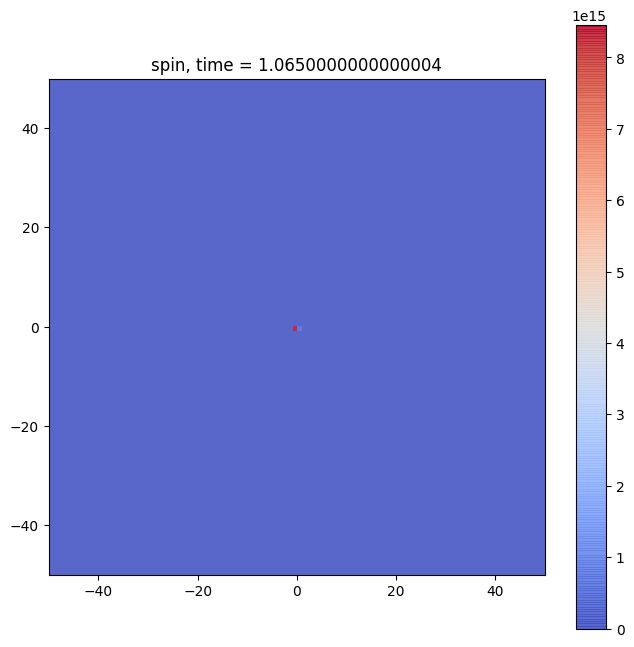

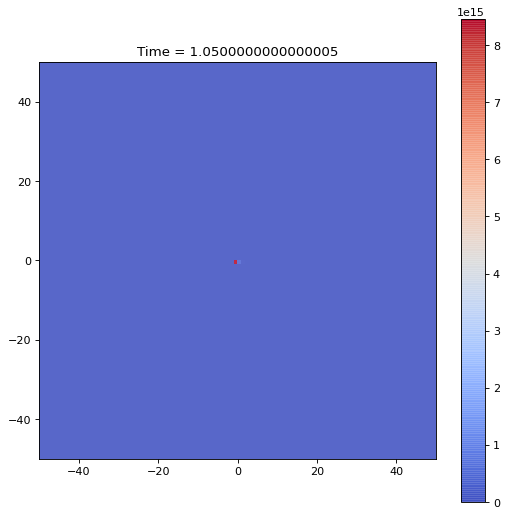

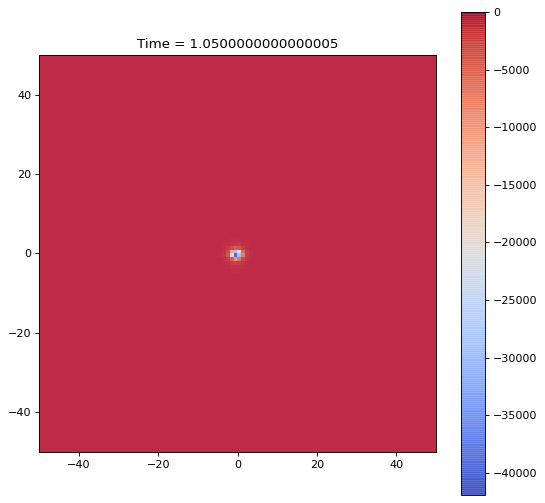

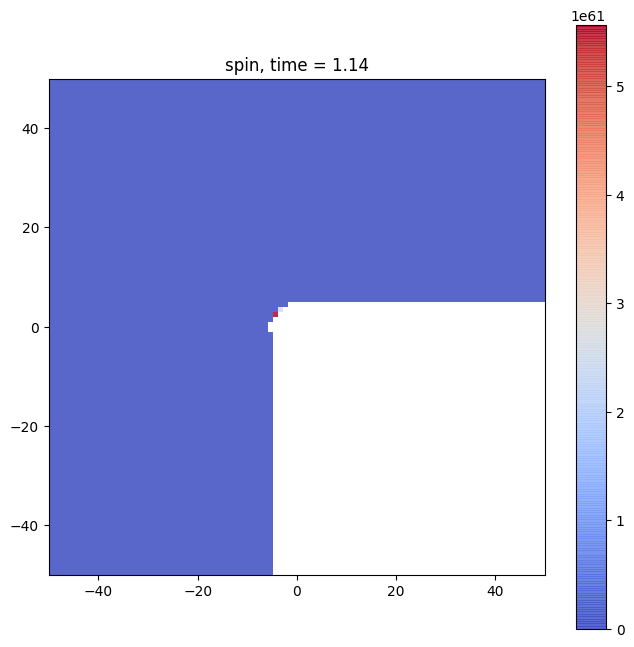

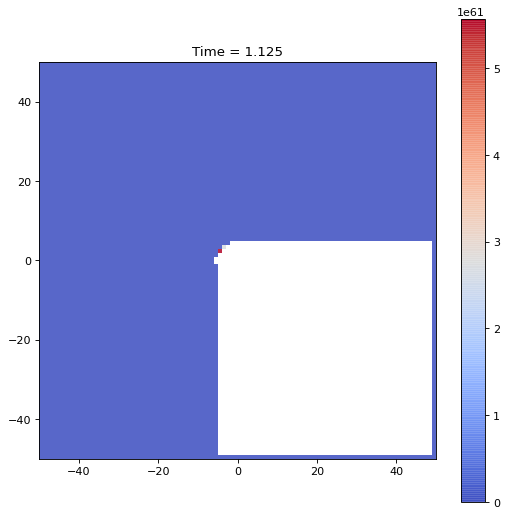

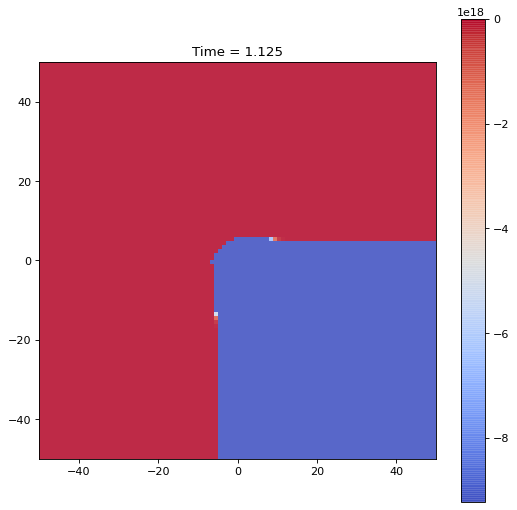

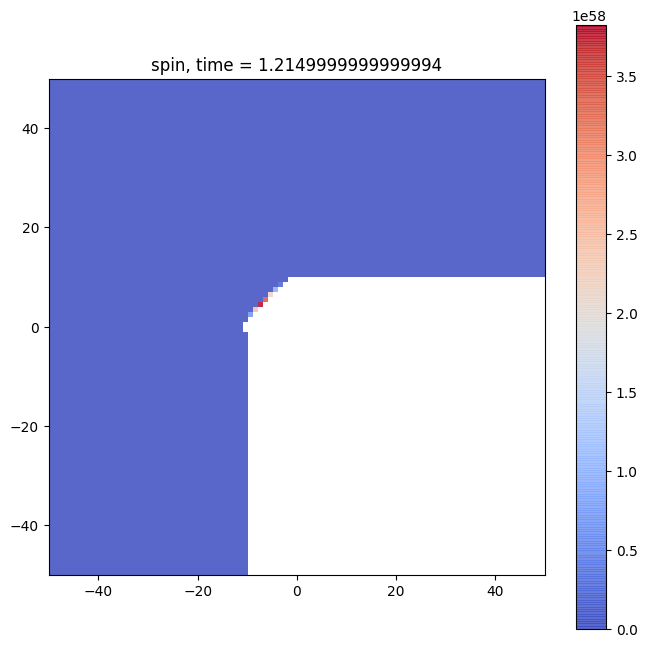

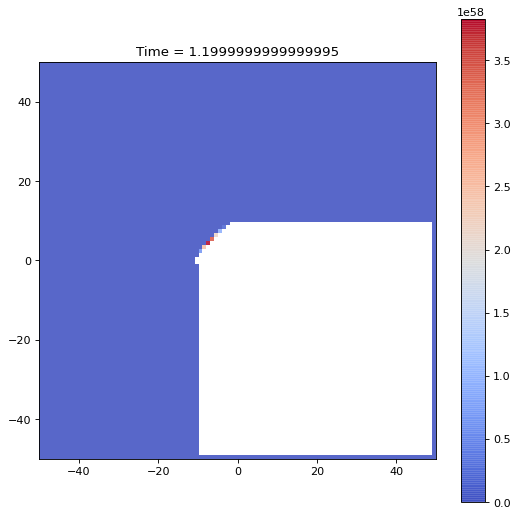

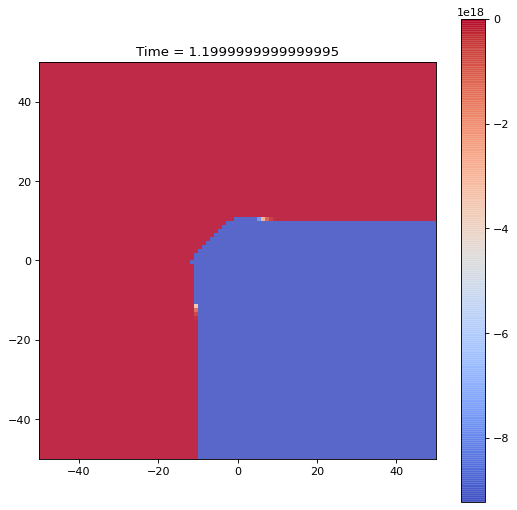

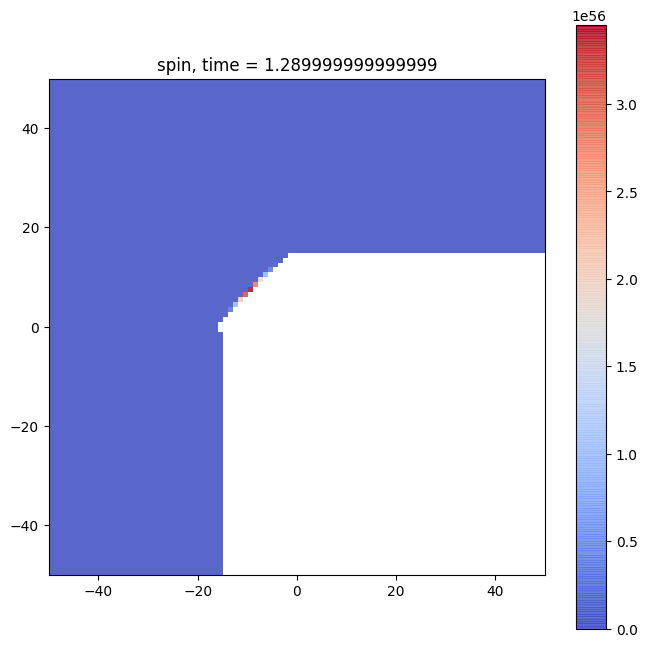

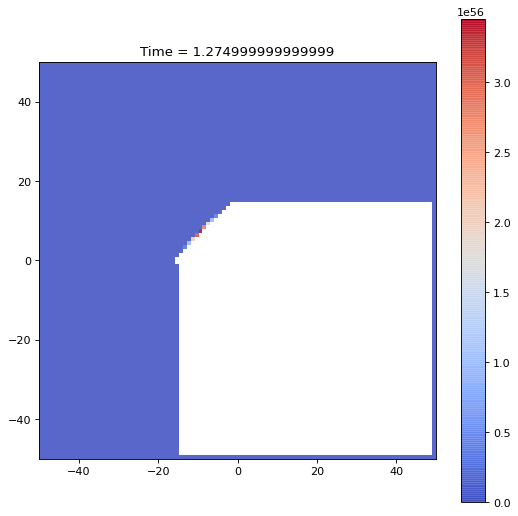

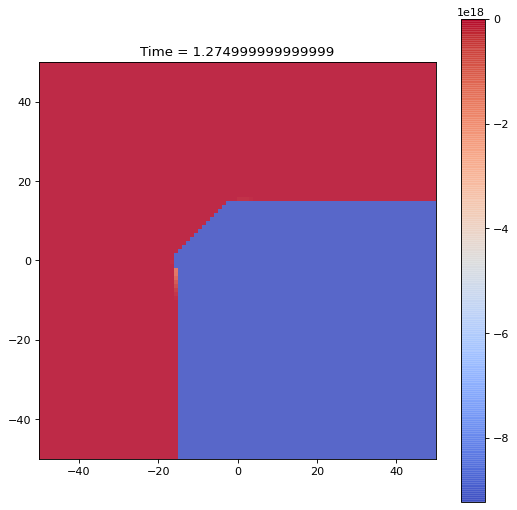

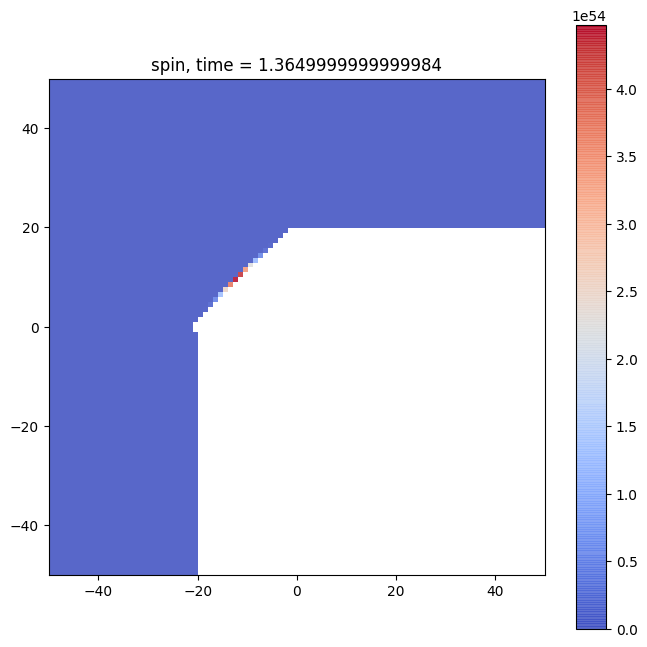

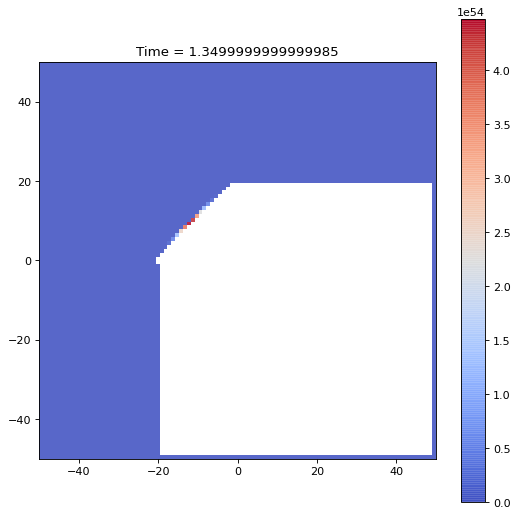

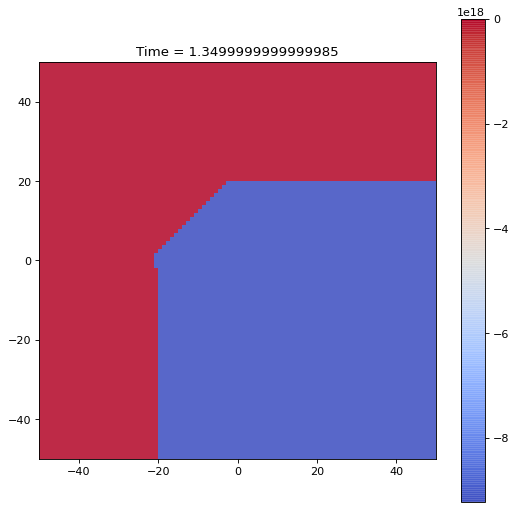

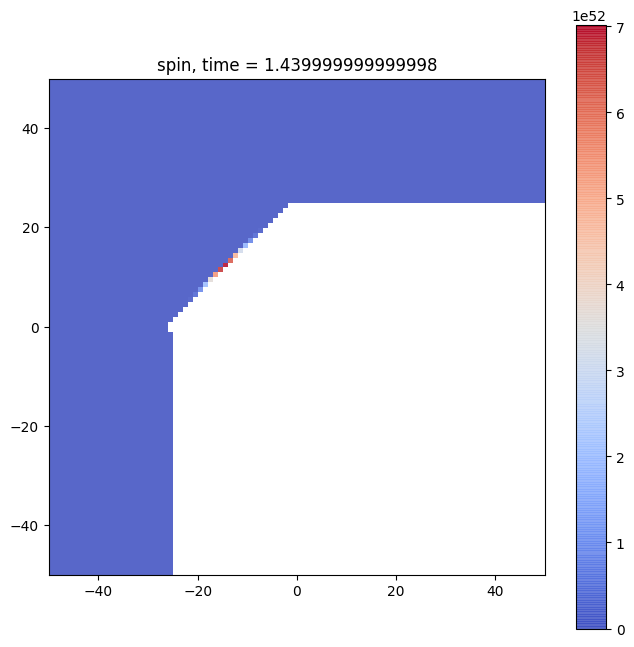

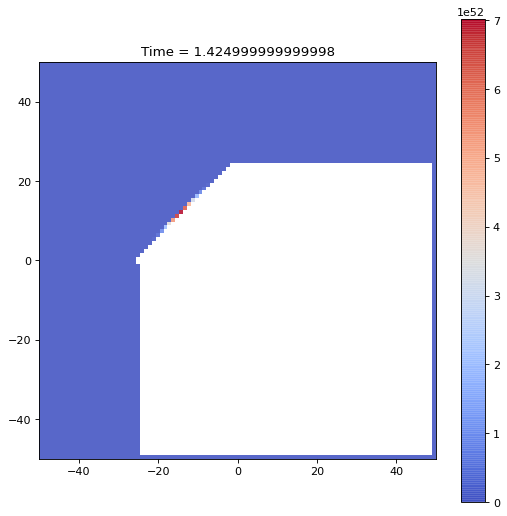

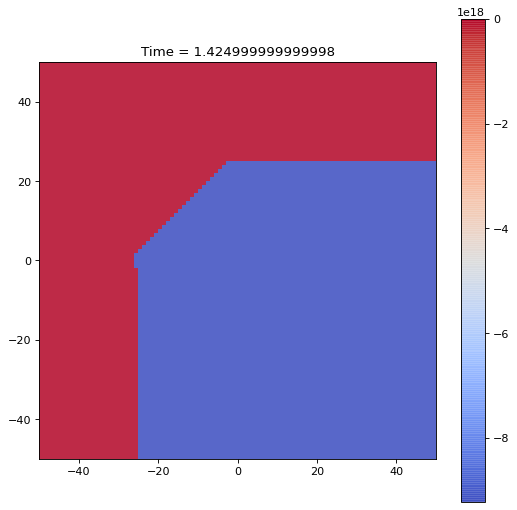

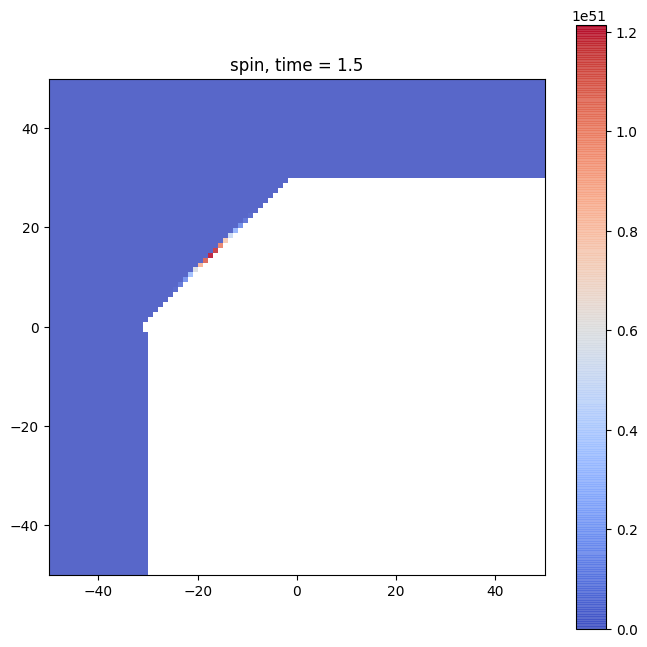

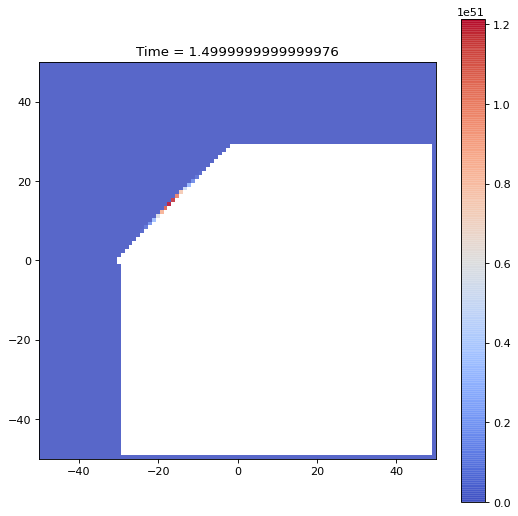

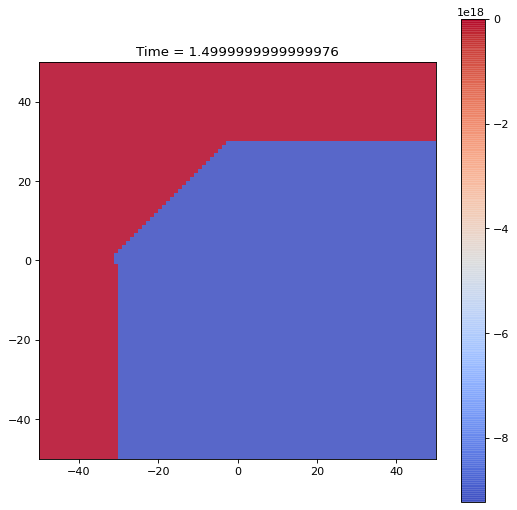

In [28]:
main(N, n, dt, tmax, tags, spin, J, sigma_x, sigma_y, eta)